# **AI Planet: Video Classification**

* This assignment is about a **Video Classification** project done in **PyTorch**.
* This project will be done on the **UCF101 dataset** which contains **101 action categories**, such as basketball, diving, and jumping jacks.
* It includes over 13,000 videos in total.


### **1. Import the necessary libraries**

In [14]:
import os
import cv2     
import math   
import torch
import shutil
import statistics
import pandas as pd
import numpy as np 
from glob import glob
from tqdm import tqdm
from statistics import mode
from IPython.display import Video
from collections import Counter
import torch.nn.functional as F
import torch.nn as nn
import torchvision.models as models
from torch.optim import lr_scheduler 
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt   
from sklearn.model_selection import train_test_split

%matplotlib inline

### **2. Setting up the dataset**

* For this simple implementation , I will just **use the training set provided with the dataset**.
* It contains 9500~ images. They will further be split up into a test and a training set.
* The **video classification will be done with a simple ResNet based image classifier**.
* For this, **the dataset has to be set up properly**, and **frames must be extracted from corresponding videos along with its labels**.

In [12]:
f = open("uc/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist/trainlist01.txt", "r")
temp = f.read()
videos = temp.split('\n')

# creating a dataframe having video names
train_df = pd.DataFrame()
train_df['video_name'] = videos
train_df = train_df[:-1]
print(train_df.shape)
train_df.head()

(9537, 1)


,video_name
0,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c01.avi 1
1,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c02.avi 1
2,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c03.avi 1
3,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c04.avi 1
4,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c05.avi 1


* Creating tags for videos.

In [13]:
train_labels = []

for i in range(train_df.shape[0]):
    train_labels.append(train_df['video_name'][i].split('/')[0])   
    
train_df['label'] = train_labels

In [14]:
train_df

,video_name,label
0,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c01.avi 1,ApplyEyeMakeup
1,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c02.avi 1,ApplyEyeMakeup
2,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c03.avi 1,ApplyEyeMakeup
3,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c04.avi 1,ApplyEyeMakeup
4,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c05.avi 1,ApplyEyeMakeup
...,...,...
9532,YoYo/v_YoYo_g25_c01.avi 101,YoYo
9533,YoYo/v_YoYo_g25_c02.avi 101,YoYo
9534,YoYo/v_YoYo_g25_c03.avi 101,YoYo
9535,YoYo/v_YoYo_g25_c04.avi 101,YoYo


* Creating folders as per the classes to feed it into pytorch's ImageFolder() to complile the dataset.  

In [89]:
folders = train_df.label.unique()
for i in folders:
    path = 'train1/' + i
    os.mkdir(path)
    
folders = train_df.label.unique()
for i in folders:
    path = 'test1/' + i
    os.mkdir(path)

* In the code below, **some frames are taken from each video and then saved as jpg files.**

In [59]:
# storing the frames from training videos
for i in tqdm(range(train_df.shape[0])):
    count = 0
    videoFile = train_df['video_name'][i]
    cap = cv2.VideoCapture('uc/UCF101/UCF-101/' + videoFile.split(' ')[0])   # capturing the video from the given path
    frameRate = cap.get(5) #frame rate
    x=1
    while(cap.isOpened()):
        frameId = cap.get(1) #current frame number
        ret, frame = cap.read()
        if (ret != True):
            break
        if (frameId % math.floor(frameRate) == 0):
            # storing the frames in a new folder named train_1
            filename = 'train1/' + videoFile.split('/')[0] + '/' + videoFile.split('/')[1].split(' ')[0] +"_frame%d.jpg" % count;count+=1
            cv2.imwrite(filename, frame)
    cap.release()

100%|██████████████████████████████████████████████████████████████████████████████| 9537/9537 [07:15<00:00, 21.89it/s]


* A dataframe is made with all these images, so that they can be split into training and test sets.

In [36]:
images = glob("train/*.jpg")
train_image = []
train_class = []

for i in tqdm(range(len(images))):
    # creating the image name
    train_image.append(images[i].split('\\')[1])
    # creating the class of image
    train_class.append(images[i].split('\\')[1].split('_')[1])
    
# storing the images and their class in a dataframe
train_data = pd.DataFrame()
train_data['image'] = train_image
train_data['class'] = train_class

# converting the dataframe into csv file 
train_data.to_csv('train_new.csv',header=True, index=False)

100%|████████████████████████████████████████████████████████████████████████| 73844/73844 [00:00<00:00, 982562.03it/s]


In [30]:
final_df = pd.read_csv('train_new.csv')
final_df

,image,class
0,v_ApplyEyeMakeup_g08_c01.avi_frame0.jpg,ApplyEyeMakeup
1,v_ApplyEyeMakeup_g08_c01.avi_frame1.jpg,ApplyEyeMakeup
2,v_ApplyEyeMakeup_g08_c01.avi_frame2.jpg,ApplyEyeMakeup
3,v_ApplyEyeMakeup_g08_c01.avi_frame3.jpg,ApplyEyeMakeup
4,v_ApplyEyeMakeup_g08_c01.avi_frame4.jpg,ApplyEyeMakeup
...,...,...
73839,v_YoYo_g25_c05.avi_frame3.jpg,YoYo
73840,v_YoYo_g25_c05.avi_frame4.jpg,YoYo
73841,v_YoYo_g25_c05.avi_frame5.jpg,YoYo
73842,v_YoYo_g25_c05.avi_frame6.jpg,YoYo


* **The dataset is split into traing and test sets**.

In [110]:
new_train_df, new_test_df = train_test_split(final_df, random_state=42, test_size=0.2)

* These image files rom the train and test sets are stored in the folder thay is named after their corresponding label.
* eg: **train1/video_label/video_file_name_frame01.jpg** => **train1/ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c01.avi_frame4.jpg**
* This is done to make sure the dataset/dataloaders are created without any problems using pyTorch's ImageFolder().

In [117]:
for index, row in tqdm(new_train_df.iterrows()):
    file = 'train/' + row['image']
    dest = 'train1/' +  row['class'] + '/' +  row['image'] 
    shutil.copy(file, dest)
    
for index, row in tqdm(new_test_df.iterrows()):
    file = 'train/' + row['image'] 
    dest = 'test1/' +  row['class'] + '/' +  row['image']
    shutil.copy(file, dest)

59075it [04:30, 218.48it/s]
14769it [01:07, 219.63it/s]


### **3. Data Augmentation and Creating DataLoaders**

* Image and batch size are set

In [2]:
image_size = 240
batch_size = 32

* **Data Augmentations are applied to the images** and **converted to tensors to be fed into the model**.
* Here **normalization was not applied**, as its stats were not given for this dataset.
* Imagenet stats could have been used, not were excluded for some simplicity.

In [3]:
train_tfms = tt.Compose([tt.RandomHorizontalFlip(p=0.5), 
                         tt.RandomResizedCrop(image_size, scale=(0.5,0.9), ratio=(1, 1)), 
                         tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.RandomRotation(10),
                         tt.ToTensor()])

valid_tfms = tt.Compose([tt.ToTensor()])

In [4]:
from torch.utils.data.dataloader import DataLoader

train_ds = ImageFolder('train1', train_tfms)
valid_ds = ImageFolder('test1', valid_tfms)

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(valid_ds, batch_size*2, num_workers=4, pin_memory=True)

In [5]:
# Helper functions to show a batch

from torchvision.utils import make_grid

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=36):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach()[:nmax], nrow=6).permute(1, 2, 0))

def show_batch(dl, nmax=36):
    for images, _ in dl:
        show_images(images, nmax)
        break

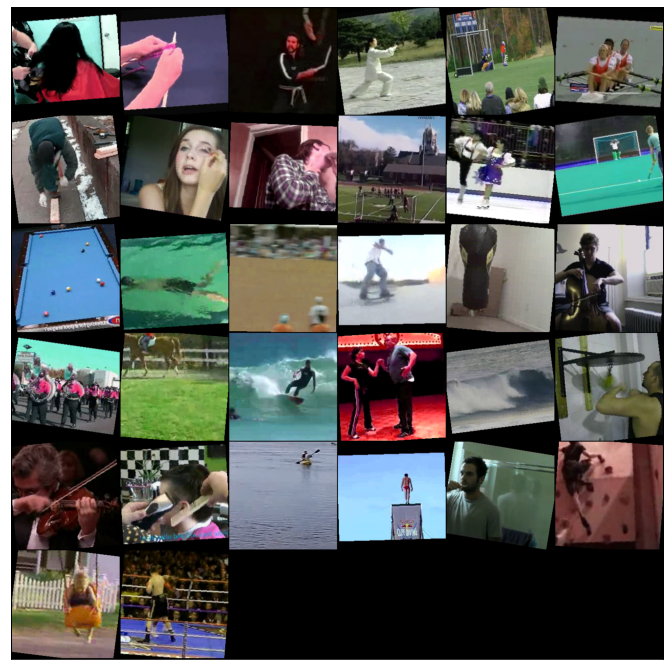

In [6]:
show_batch(train_dl)

### **4. GPU utility functions**

In [5]:
# Helper functions to tranfer Tensors and DataLoaders to the GPU for faster training

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

### **5. Defining the Model Class and metric functions**

In [6]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

**Transfer Learning model - ResNet18**
* As mentioned earlier, **this project will be done with the help of a image classification model**.
* I have chosen **apply transfer learning on the pretrained ResNet18 model**.
* ResNet34 was also trained and tested, but it lead to greater inference and training time with the same accuracy.

* **Just image classification is not the ideal solution for video classification**.
* A **combination of a CNN(feature extracter) and a LSTM/RNN** or a **3D CNN** would lead to better results as video classification has an element of dynamism and also depends on previous frames as well.
* Unfortunately I did not get enough time to test and train this approach. 
* So for now, a ResNet as will be used.

In [7]:
class VideoResnet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
                          nn.Linear(num_ftrs, 256),
                          nn.ReLU(),
                          nn.Dropout(0.4),
                          nn.Linear(256, 101))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [8]:
device = get_default_device()
device

device(type='cuda')

In [9]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

### **6. Training the Model**

* Defining the training loop

In [12]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [15]:
model = to_device(VideoResnet(), device)

In [62]:
%%time
history = [evaluate(model, val_dl)]
history

Wall time: 20.7 s


[{'val_loss': 4.613047122955322, 'val_acc': 0.005005411338061094}]

* **This is how the model performs without training**.
* This makes sense because if random predictions are made, the accuracy will be around 1/101.

In [64]:
epochs = 5
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

* A couple of regularization techniques like **learning rate scheduler**, **gradient clipping** and **weight decay** is used.
* The optimizer function is the Adam function.
* The model will be frozen and trained for a couple of epochs, then it will be trained for a longer time while being unfrozen.

In [63]:
model.freeze()

In [65]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

Epoch [0], last_lr: 0.00760, train_loss: 4.2286, val_loss: 4.4332, val_acc: 0.0153
Epoch [1], last_lr: 0.00950, train_loss: 4.2518, val_loss: 4.1870, val_acc: 0.0522
Epoch [2], last_lr: 0.00611, train_loss: 4.1782, val_loss: 4.1118, val_acc: 0.0844
Epoch [3], last_lr: 0.00188, train_loss: 4.1240, val_loss: 4.0663, val_acc: 0.0878
Epoch [4], last_lr: 0.00000, train_loss: 4.0839, val_loss: 4.0387, val_acc: 0.1174
Wall time: 13min 22s


In [66]:
model.unfreeze()

In [67]:
%%time
history += fit_one_cycle(20, 0.001, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

Epoch [0], last_lr: 0.00010, train_loss: 4.0743, val_loss: 4.0387, val_acc: 0.1163
Epoch [1], last_lr: 0.00028, train_loss: 4.0700, val_loss: 4.0262, val_acc: 0.1171
Epoch [2], last_lr: 0.00052, train_loss: 4.0595, val_loss: 4.0209, val_acc: 0.1401
Epoch [3], last_lr: 0.00076, train_loss: 4.0421, val_loss: 3.9909, val_acc: 0.1830
Epoch [4], last_lr: 0.00094, train_loss: 4.0233, val_loss: 3.9622, val_acc: 0.2159
Epoch [5], last_lr: 0.00100, train_loss: 4.0041, val_loss: 3.9538, val_acc: 0.2179
Epoch [6], last_lr: 0.00099, train_loss: 3.9847, val_loss: 3.9524, val_acc: 0.2030
Epoch [7], last_lr: 0.00095, train_loss: 3.9677, val_loss: 3.9193, val_acc: 0.2537
Epoch [8], last_lr: 0.00089, train_loss: 3.9538, val_loss: 3.8933, val_acc: 0.2885
Epoch [9], last_lr: 0.00081, train_loss: 3.9431, val_loss: 3.8856, val_acc: 0.3000
Epoch [10], last_lr: 0.00072, train_loss: 3.9336, val_loss: 3.8797, val_acc: 0.3031
Epoch [11], last_lr: 0.00061, train_loss: 3.9230, val_loss: 3.8666, val_acc: 0.3255
Ep

* So after about 25 epochs, the **validation accuracy is 40%**.

In [79]:
%%time
history += fit_one_cycle(25, 0.0005, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

Epoch [0], last_lr: 0.00004, train_loss: 3.8707, val_loss: 3.8158, val_acc: 0.4009
Epoch [1], last_lr: 0.00010, train_loss: 3.8711, val_loss: 3.8238, val_acc: 0.3879
Epoch [2], last_lr: 0.00019, train_loss: 3.8723, val_loss: 3.8179, val_acc: 0.3929
Epoch [3], last_lr: 0.00029, train_loss: 3.8742, val_loss: 3.8230, val_acc: 0.4024
Epoch [4], last_lr: 0.00038, train_loss: 3.8758, val_loss: 3.8312, val_acc: 0.3792
Epoch [5], last_lr: 0.00045, train_loss: 3.8762, val_loss: 3.8219, val_acc: 0.4030
Epoch [6], last_lr: 0.00049, train_loss: 3.8756, val_loss: 3.8195, val_acc: 0.4163
Epoch [7], last_lr: 0.00050, train_loss: 3.8741, val_loss: 3.8321, val_acc: 0.3967
Epoch [8], last_lr: 0.00049, train_loss: 3.8706, val_loss: 3.8171, val_acc: 0.4024
Epoch [9], last_lr: 0.00048, train_loss: 3.8656, val_loss: 3.8124, val_acc: 0.4179
Epoch [10], last_lr: 0.00045, train_loss: 3.8599, val_loss: 3.8112, val_acc: 0.4272
Epoch [11], last_lr: 0.00042, train_loss: 3.8570, val_loss: 3.8181, val_acc: 0.4325
Ep

* After about 50 epochs, **the validation accuracy is 54%**.
* Lets see if the model can be fine tuned a little more.

In [87]:
%%time
history += fit_one_cycle(10, 0.00005, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

Epoch [0], last_lr: 0.00001, train_loss: 3.8146, val_loss: 3.7674, val_acc: 0.5320
Epoch [1], last_lr: 0.00004, train_loss: 3.8151, val_loss: 3.7674, val_acc: 0.5431
Epoch [2], last_lr: 0.00005, train_loss: 3.8154, val_loss: 3.7645, val_acc: 0.5436
Epoch [3], last_lr: 0.00005, train_loss: 3.8165, val_loss: 3.7664, val_acc: 0.5379
Epoch [4], last_lr: 0.00004, train_loss: 3.8141, val_loss: 3.7716, val_acc: 0.5337
Epoch [5], last_lr: 0.00003, train_loss: 3.8132, val_loss: 3.7672, val_acc: 0.5358
Epoch [6], last_lr: 0.00002, train_loss: 3.8138, val_loss: 3.7654, val_acc: 0.5379
Epoch [7], last_lr: 0.00001, train_loss: 3.8117, val_loss: 3.7633, val_acc: 0.5491
Epoch [8], last_lr: 0.00000, train_loss: 3.8115, val_loss: 3.7669, val_acc: 0.5372
Epoch [9], last_lr: 0.00000, train_loss: 3.8113, val_loss: 3.7666, val_acc: 0.5371
Wall time: 27min 18s


* Unfortunately, the model did not improve.

#### **Training Results**

* At the end of training, **the final validation accuracy is 54~%**.
* Now **this may not look very good, but it is actually not bad**.
* There could have been more data to train with.
* But more importantly, **there are a massive amount of classes to classify**.
* **Some of these classes are quite difficult to distinguish from each** other **like Javelin Throw and Pole Vault** or **Applying Makeup and Shaving Beard**.
* With a simple approach like this, this is not a bad result.
* **Perhaps with a more complex model, better results could have been obtained**.

* Lets look at some graphs to check the training of the model.

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [24]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [26]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

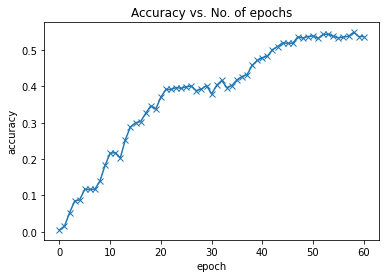

In [88]:
plot_accuracies(history)

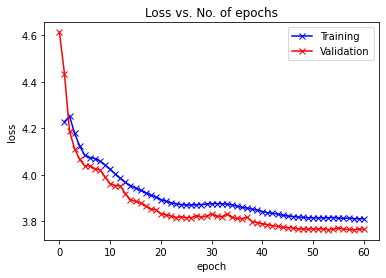

In [89]:
plot_losses(history)

* This is the most important graph, looks like there are no signs of overfitting.
* Both the training and validation loss are decreasing with epochs.

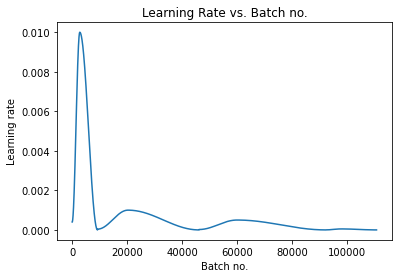

In [90]:
plot_lrs(history)

In [91]:
torch.save(model.state_dict(), 'resnet18-60epoch.pth')

In [16]:
# load the model

model = to_device(VideoResnet(), device)
model.load_state_dict(torch.load('resnet18-60epoch.pth'))
model.eval()

VideoResnet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [73]:
evaluate(model, val_dl)

{'val_loss': 3.7666311264038086, 'val_acc': 0.5370602011680603}

### **7. Testing the Model**

**Testing the model on images**

In [17]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label|
    return train_ds.classes[preds[0].item()]

Label: ApplyEyeMakeup , Predicted: ShavingBeard
Wall time: 5.6 s


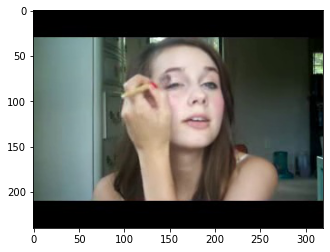

In [18]:
%%time
img, label = valid_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: PlayingGuitar , Predicted: PlayingGuitar
Wall time: 52.8 ms


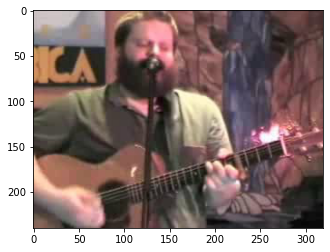

In [19]:
%%time
img, label = valid_ds[9000]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: PoleVault , Predicted: PoleVault
Wall time: 185 ms


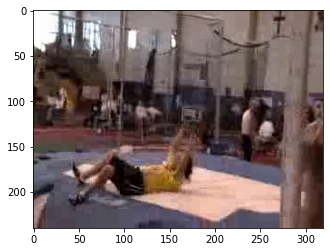

In [20]:
%%time
img, label = valid_ds[10000]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

**Testing the model on videos**

* The model is finally tested for videos.
* Instead of passing each frame from the video to the model, **alternate frames are passed to the model to save time**.
* The final prediction is the most frequent prediction that the model did for all the frames that it was passed with.
* The percentage of the different predictions are also given as a psuedo-confidence of the model.

In [21]:
def predictVideoClass(video_path, confidences = False):
    video = cv2.VideoCapture(video_path)
    predictions = []
    odd_count = 0
    frame_count = 0
    while video.isOpened():
        ret, frame = video.read()
        frame_count=frame_count+1
        
        if not ret:
            break

        if frame_count % 2 == 0:
            continue
    
        convert_tensor = tt.ToTensor()
        tensor_frame = convert_tensor(frame)
    
        with torch.no_grad():
            pred = predict_image(tensor_frame, model)
        predictions.append(pred)
        
        if frame_count == 5:
            video_frame = tensor_frame
            
    plt.imshow(video_frame.permute(1, 2, 0))
    print('No. of frames predicted:', frame_count//2, '; Actual:', frame_count)
    print('Predicted Class: ', mode(predictions), '\n')
    
    if confidences:
        counts = Counter(predictions)
        total_items = len(predictions)
        
        for item, count in counts.items():
            percentage = (count / total_items) * 100
            print(f"{item}: {percentage:.2f}%")

* Unfortunately Jupyter was giving a lot of problems for embedding of videos.
* So a frame from the video is displayed as a placeholder.
* **This is also the case with the streamlit web-app (did not support embedding of avi videos)**.

No. of frames predicted: 123 ; Actual: 247
Predicted Class:  Surfing 

Surfing: 80.49%
Rowing: 6.50%
LongJump: 13.01%


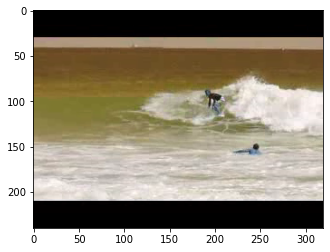

In [22]:
predictVideoClass('uc/UCF101/UCF-101/Surfing/v_Surfing_g13_c02.avi', confidences = True)

No. of frames predicted: 125 ; Actual: 251
Predicted Class:  PlayingGuitar 

PlayingGuitar: 100.00%


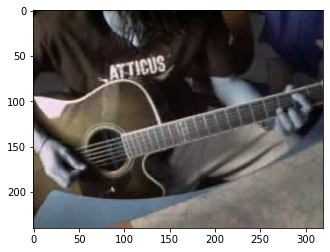

In [23]:
predictVideoClass('uc/UCF101/UCF-101/PlayingGuitar/v_PlayingGuitar_g15_c03.avi', confidences = True)

No. of frames predicted: 100 ; Actual: 201
Predicted Class:  BoxingPunchingBag 

BoxingPunchingBag: 85.00%
WritingOnBoard: 11.00%
BlowDryHair: 4.00%


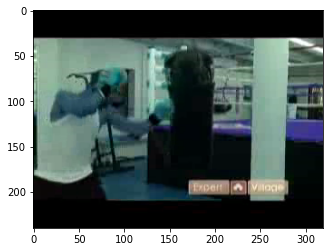

In [24]:
predictVideoClass('uc/UCF101/UCF-101/BoxingPunchingBag/v_BoxingPunchingBag_g15_c05.avi', confidences = True)